In [1]:
!pip install flwr torch torchvision matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121 kB 4.7 MB/s 


In [3]:
!pip install -U flwr['simulation']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cpu using PyTorch 1.13.0+cu116 and Flower 1.1.0


In [5]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
NUM_CLIENTS = 10

In [7]:
BATCH_SIZE = 32

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


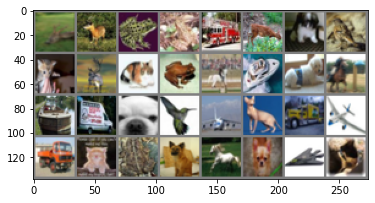

 deer  deer  frog  frog truck  deer   dog  bird   cat  deer   cat  frog horse  ship   dog horse  ship truck   dog  bird plane   cat truck plane truck   cat  frog   dog horse   dog plane   cat


In [8]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
################################################
#images, labels = iter(next(trainloaders[0])) #REPLACE BY

dataiter = iter(trainloaders[0])
datax = next(dataiter) 
images, labels = datax
################################################

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(32)))

In [9]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [11]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.061121432065963745, accuracy 0.298
Epoch 2: validation loss 0.057760628938674924, accuracy 0.328
Epoch 3: validation loss 0.05681021881103516, accuracy 0.366
Epoch 4: validation loss 0.052787667989730835, accuracy 0.378
Epoch 5: validation loss 0.052830126285552975, accuracy 0.396
Final test set performance:
	loss 0.04927862521409988
	accuracy 0.4212


In [12]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [14]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [15]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flower 2022-12-29 17:19:09,355 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2022-12-29 17:19:11,314	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2022-12-29 17:19:14,388 | app.py:174 | Flower VCE: Ray initialized with resources: {'memory': 7877502567.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3938751283.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'memory': 7877502567.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3938751283.0}
INFO flower 2022-12-29 17:19:14,408 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-12-29 17:19:14,421 | server.py:270 | Requesting initial parameters from one random client
INFO:flower:Requesting initial parameters from one random client
INFO flower 2022-12-29 17:19:19,255 | server.p

History (loss, distributed):
	round 1: 0.06156458325386047
	round 2: 0.053356006908416756
	round 3: 0.050537631273269656
	round 4: 0.04849435739517212
	round 5: 0.047749141502380375

In [16]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [17]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flower 2022-12-29 17:25:58,382 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2022-12-29 17:26:03,177	WARNING services.py:1884 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 2276392960 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.11gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-12-29 17:26:04,453	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2022-12-29 17:26:07,676 | app.py:174 | Flower VCE: Ray initialized with resources: {'memory': 8016811623.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 4008405811.0, 'CPU': 2.0}
INFO:flo

History (loss, distributed):
	round 1: 0.06216430559158326
	round 2: 0.0539857635974884
	round 3: 0.0513447223186493
	round 4: 0.04952703757286072
	round 5: 0.04848203201293945
History (metrics, distributed):
{'accuracy': [(1, 0.3156), (2, 0.3872), (3, 0.40520000000000006), (4, 0.4284), (5, 0.4284)]}